# 3 layer LSTM Encoder Decoder, dropout. 30 day input, 7 day forecast

In [23]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, accuracy_score
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
save_dir = 'models/lstm4.2'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
data = df.values

In [3]:
num_input = 30
num_out = 7
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (637, 30, 25)
train_y shape (637, 7, 1)
dev_X shape (80, 30, 25)
dev_y shape (80, 7, 1)
test_X shape (80, 30, 25)
test_y shape (80, 7, 1)
train_y_acc shape (637, 7, 1)
dev_y_acc shape (80, 7, 1)
test_y_acc shape (80, 7, 1)


In [39]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0001
decay = 1e-6
dropout_rate = 0.3
epochs = 400
batch_size = 32

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=input_shape, kernel_regularizer=regularizers.l2(0.01)))
model.add(RepeatVector(num_out))
model.add(Dropout(dropout_rate))
model.add(CuDNNLSTM(200, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
model.add(TimeDistributed(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="binary_crossentropy", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_9 (CuDNNLSTM)     (None, 200)               181600    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)    (None, 7, 200)            321600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 200)            0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 7, 1)              101       
Total para

In [40]:
history = model_funcs.train(
    model,
    train_X,
    train_y_acc,
    (dev_X, dev_y_acc),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 400 epochs, 32 batch size
Train on 637 samples, validate on 80 samples
Epoch 1/400
637/637 [==============================] - 1s 2ms/step - loss: 5.5716 - val_loss: 5.4064
Epoch 2/400
637/637 [==============================] - 0s 634us/step - loss: 5.2502 - val_loss: 5.1015
Epoch 3/400
637/637 [==============================] - 0s 633us/step - loss: 4.9502 - val_loss: 4.8148
Epoch 4/400
637/637 [==============================] - 0s 630us/step - loss: 4.6698 - val_loss: 4.5437
Epoch 5/400
637/637 [==============================] - 0s 626us/step - loss: 4.4075 - val_loss: 4.2949
Epoch 6/400
637/637 [==============================] - 0s 625us/step - loss: 4.1627 - val_loss: 4.0577
Epoch 7/400
637/637 [==============================] - 0s 629us/step - loss: 3.9330 - val_loss: 3.8368
Epoch 8/400
637/637 [==============================] - 0s 629us/step - loss: 3.7192 - val_loss: 3.6277
Epoch 9/400
637/637 [==============================] - 0s 627us/step - los

Epoch 79/400
637/637 [==============================] - 0s 622us/step - loss: 0.7104 - val_loss: 0.7257
Epoch 80/400
637/637 [==============================] - 0s 628us/step - loss: 0.7080 - val_loss: 0.7237
Epoch 81/400
637/637 [==============================] - 0s 622us/step - loss: 0.7070 - val_loss: 0.7219
Epoch 82/400
637/637 [==============================] - 0s 626us/step - loss: 0.7080 - val_loss: 0.7239
Epoch 83/400
637/637 [==============================] - 0s 623us/step - loss: 0.7055 - val_loss: 0.7186
Epoch 84/400
637/637 [==============================] - 0s 624us/step - loss: 0.7032 - val_loss: 0.7221
Epoch 85/400
637/637 [==============================] - 0s 623us/step - loss: 0.7037 - val_loss: 0.7164
Epoch 86/400
637/637 [==============================] - 0s 623us/step - loss: 0.7012 - val_loss: 0.7202
Epoch 87/400
637/637 [==============================] - 0s 626us/step - loss: 0.6997 - val_loss: 0.7189
Epoch 88/400
637/637 [==============================] - 0s 624us

637/637 [==============================] - 0s 626us/step - loss: 0.6848 - val_loss: 0.7012
Epoch 158/400
637/637 [==============================] - 0s 632us/step - loss: 0.6848 - val_loss: 0.7000
Epoch 159/400
637/637 [==============================] - 0s 618us/step - loss: 0.6842 - val_loss: 0.6999
Epoch 160/400
637/637 [==============================] - 0s 624us/step - loss: 0.6841 - val_loss: 0.6996
Epoch 161/400
637/637 [==============================] - 0s 637us/step - loss: 0.6844 - val_loss: 0.6999
Epoch 162/400
637/637 [==============================] - 0s 626us/step - loss: 0.6840 - val_loss: 0.6998
Epoch 163/400
637/637 [==============================] - 0s 630us/step - loss: 0.6842 - val_loss: 0.6988
Epoch 164/400
637/637 [==============================] - 0s 623us/step - loss: 0.6842 - val_loss: 0.7015
Epoch 165/400
637/637 [==============================] - 0s 628us/step - loss: 0.6846 - val_loss: 0.7046
Epoch 166/400
637/637 [==============================] - 0s 625us/ste

637/637 [==============================] - 0s 625us/step - loss: 0.6839 - val_loss: 0.7045
Epoch 236/400
637/637 [==============================] - 0s 625us/step - loss: 0.6851 - val_loss: 0.6970
Epoch 237/400
637/637 [==============================] - 0s 624us/step - loss: 0.6831 - val_loss: 0.6971
Epoch 238/400
637/637 [==============================] - 0s 623us/step - loss: 0.6828 - val_loss: 0.6975
Epoch 239/400
637/637 [==============================] - 0s 624us/step - loss: 0.6829 - val_loss: 0.6974
Epoch 240/400
637/637 [==============================] - 0s 624us/step - loss: 0.6829 - val_loss: 0.6985
Epoch 241/400
637/637 [==============================] - 0s 624us/step - loss: 0.6829 - val_loss: 0.6982
Epoch 242/400
637/637 [==============================] - 0s 624us/step - loss: 0.6835 - val_loss: 0.6983
Epoch 243/400
637/637 [==============================] - 0s 622us/step - loss: 0.6827 - val_loss: 0.6954
Epoch 244/400
637/637 [==============================] - 0s 623us/ste

637/637 [==============================] - 0s 625us/step - loss: 0.6836 - val_loss: 0.6982
Epoch 314/400
637/637 [==============================] - 0s 626us/step - loss: 0.6825 - val_loss: 0.6982
Epoch 315/400
637/637 [==============================] - 0s 624us/step - loss: 0.6828 - val_loss: 0.6982
Epoch 316/400
637/637 [==============================] - 0s 625us/step - loss: 0.6822 - val_loss: 0.6982
Epoch 317/400
637/637 [==============================] - 0s 627us/step - loss: 0.6838 - val_loss: 0.6982
Epoch 318/400
637/637 [==============================] - 0s 626us/step - loss: 0.6841 - val_loss: 0.7087
Epoch 319/400
637/637 [==============================] - 0s 626us/step - loss: 0.6878 - val_loss: 0.7135
Epoch 320/400
637/637 [==============================] - 0s 629us/step - loss: 0.6866 - val_loss: 0.7070
Epoch 321/400
637/637 [==============================] - 0s 628us/step - loss: 0.6867 - val_loss: 0.7085
Epoch 322/400
637/637 [==============================] - 0s 627us/ste

637/637 [==============================] - 0s 626us/step - loss: 0.6817 - val_loss: 0.6982
Epoch 392/400
637/637 [==============================] - 0s 624us/step - loss: 0.6846 - val_loss: 0.6981
Epoch 393/400
637/637 [==============================] - 0s 626us/step - loss: 0.6818 - val_loss: 0.6948
Epoch 394/400
637/637 [==============================] - 0s 623us/step - loss: 0.6824 - val_loss: 0.6977
Epoch 395/400
637/637 [==============================] - 0s 626us/step - loss: 0.6816 - val_loss: 0.6961
Epoch 396/400
637/637 [==============================] - 0s 626us/step - loss: 0.6812 - val_loss: 0.6973
Epoch 397/400
637/637 [==============================] - 0s 625us/step - loss: 0.6825 - val_loss: 0.6978
Epoch 398/400
637/637 [==============================] - 0s 623us/step - loss: 0.6815 - val_loss: 0.6961
Epoch 399/400
637/637 [==============================] - 0s 625us/step - loss: 0.6816 - val_loss: 0.6980
Epoch 400/400
637/637 [==============================] - 0s 630us/ste

In [41]:
# predicted_train = model.predict(train_X).reshape(-1,1)
# true_train = train_y_acc.reshape(-1,1)

predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out].reshape(-1,1)
true_train = train_y_acc[:, 0].reshape(-1,1)
prepredicted_train_binary = np.array(predicted_train > 0.5, dtype=np.int32)
print('Train Acc:', accuracy_score(prepredicted_train_binary, true_train))

true_dev = dev_y_acc[:, 0].reshape(-1,1)
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out].reshape(-1,1)[:true_dev.shape[0]]
prepredicted_dev_binary = np.array(predicted_dev > 0.5, dtype=np.int32)
print('Dev Acc:', accuracy_score(prepredicted_dev_binary, true_dev))

true_test = test_y_acc[:, 0].reshape(-1,1)
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out].reshape(-1,1)[:true_test.shape[0]]
prepredicted_test_binary = np.array(predicted_test > 0.5, dtype=np.int32)
print('Test Acc:', accuracy_score(prepredicted_test_binary, true_test))

Train Acc: 0.554160125588697
Dev Acc: 0.4875
Test Acc: 0.6


In [42]:
train_scores = utils.get_scores(predicted_train, true_train, num_out)
print("Acc Score:", np.sum(train_scores))

dev_scores = utils.get_scores(predicted_dev, true_dev, num_out)
print("Acc Dev:", np.sum(dev_scores))

test_scores = utils.get_scores(predicted_test, true_test, num_out)
print("Acc Test:", np.sum(test_scores))

Acc Score: 0.7873116433620453
Acc Dev: -0.008966416120529175
Acc Test: 0.17229390144348145


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


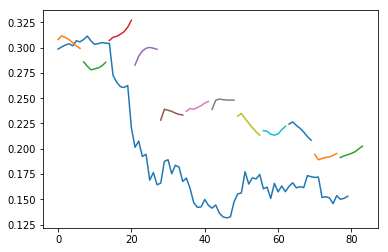

In [17]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_train = predicted_train.reshape(predicted_train.shape[0], -1)
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_dev.tolist(), true_dev, num_out)

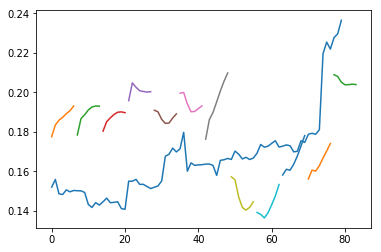

In [18]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[:, 0].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

In [19]:
print("MSE Train:", mean_squared_error(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("MSE Test:", mean_squared_error(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

MSE Train: 0.00015505207963562414
MSE Dev: 0.0045149903840654634
MSE Test: 0.0011437447249456514


In [20]:
print("Acc Train:", utils.direction_accuracy(predicted_train.reshape(-1,1)[:len(true_train)], true_train))
print("Acc Dev:", utils.direction_accuracy(predicted_dev.reshape(-1,1)[:len(true_dev)], true_dev))
print("Acc Test:", utils.direction_accuracy(predicted_test.reshape(-1,1)[:len(true_test)], true_test))

Acc Train: 0.639937106918239
Acc Dev: 0.5063291139240507
Acc Test: 0.5443037974683544


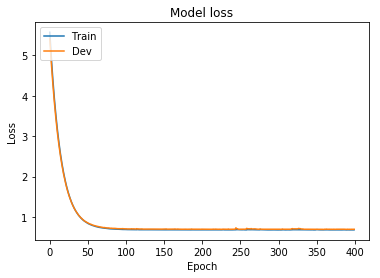

In [43]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

In [50]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'])
v = go.Scatter(y=history.history['val_loss'])

data = [v,l]
py.iplot(data, filename='line-mode')